In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from scipy import sparse
import scipy.sparse.linalg as spla
from scipy import optimize as scop


from decimal import Decimal
from datetime import datetime

In [ ]:
def GradOpTorus(Nx):
    dx = 1./Nx
    row  = []
    col  = []
    data = []

    for n in range(Nx):
        row.extend([n,n])
        col.extend([(n-1)%Nx, (n+1)%Nx])

        xleft =  -.5/dx
        xrigth =  .5/dx

        data.extend([xleft, xrigth])
    return sparse.csc_matrix((data,(row,col)), (Nx,Nx))

def HessOpTorus(Nx):
    dx = 1./Nx
    row  = []
    col  = []
    data = []

    for n in range(Nx):
        row.extend([n,n,n])
        col.extend([(n-1)%Nx, n, (n+1)%Nx])

        xleft =  1./dx**2
        xrigth =  1./dx**2
        mid = -2./dx**2

        data.extend([xleft, mid, xrigth])
    return sparse.csc_matrix((data,(row,col)), (Nx,Nx))

def EllipOp(Nx, sigma = .1, r = 1.):
    dx = 1./Nx
    row  = []
    col  = []
    data = []

    for n in range(Nx):
        row.extend([n,n,n])
        col.extend([(n-1)%Nx, n, (n+1)%Nx])

        xleft =  sigma/dx**2
        xrigth =  sigma/dx**2
        mid =  -2.*sigma/dx**2 - r

        data.extend([xleft, mid, xrigth])
    return sparse.csc_matrix((data,(row,col)), (Nx,Nx))

In [ ]:
def ParaOp(Nx, dt, sigma = .1, r = 1.):
    dx = 1./Nx
    row  = []
    col  = []
    data = []

    for n in range(Nx):
        row.extend([n,n,n])
        col.extend([(n-1)%Nx, n, (n+1)%Nx])

        xleft =  -dt*sigma/dx**2
        xrigth =  -dt*sigma/dx**2
        mid =  dt*(2.*sigma/dx**2 + r) + 1.

        data.extend([xleft, mid, xrigth])
    return sparse.csc_matrix((data,(row,col)), (Nx,Nx))


def MumfordParaOp(Nx, Nth, dt, sigth = 1., vega = 1., sgx = .01):
    dx = 1./Nx
    dth = 2.* np.pi / Nth

    row  = []
    col  = []
    data = []

    for thi in range(Nth):
        for x1i in range(Nx):
            for x2i in range(Nx):

                row.extend([thi*Nx*Nx + x1i*Nx + x2i]*7)

                col.extend([thi*Nx*Nx + x1i*Nx + (x2i+1)%Nx,
                            thi*Nx*Nx + x1i*Nx + (x2i-1)%Nx,
                            thi*Nx*Nx + ((x1i+1)%Nx)*Nx + x2i,
                            thi*Nx*Nx + ((x1i-1)%Nx)*Nx + x2i,
                            thi*Nx*Nx + x1i*Nx + x2i,
                            ((thi+1)%Nth)*Nx*Nx + x1i*Nx + x2i,
                            ((thi-1)%Nth)*Nx*Nx + x1i*Nx + x2i])

                x2down =  -dt*sgx/dx**2 + .5 * dt*vega*np.sin(thi*dth)/dx
                x2up =  -dt*sgx/dx**2 - .5 * dt*vega* np.sin(thi*dth)/dx

                x1left =  -dt*sgx/dx**2 + .5 * dt*vega*np.cos(thi*dth)/dx
                x1rigth =  -dt*sgx/dx**2 - .5 * dt*vega* np.cos(thi*dth)/dx

                mid =  dt*2.*(sigth/dth**2 + 2.*sgx/dx**2) + 1.

                thup = -dt*sigth/dth**2
                thdwn = -dt*sigth/dth**2

                data.extend([x2up, x2down, x1rigth, x1left, mid, thup, thdwn])

    return sparse.csc_matrix((data,(row,col)), (Nx*Nx*Nth,Nx*Nx*Nth))

def MumfordParaOp1D(Nx, Nth, dt, sigth = 1., vega = 1., sgx = .01):
    dx = 1./Nx
    dth = 2.* np.pi / Nth

    row  = []
    col  = []
    data = []

    for j in range(Nx*Nth):
        n,k = j//Nx, j%Nx

        row.extend([j,j,j,j,j])
        col.extend([((n+1)%Nth)*Nx + k, ((n-1)%Nth)*Nx + k, j, n*Nx + (k+1)%Nx , n*Nx + (k-1)%Nx ])

        xleft =  -dt*sgx/dx**2 + .5 * dt*vega*np.cos(n*dth)/dx
        xrigth =  -dt*sgx/dx**2 - .5 * dt*vega* np.cos(n*dth)/dx

        mid =  dt*2.*(sigth/dth**2 + sgx/dx**2) + 1.

        thup = -dt*sigth/dth**2
        thdwn = -dt*sigth/dth**2

        data.extend([thup, thdwn, mid, xleft, xrigth])
    return sparse.csc_matrix((data,(row,col)), (Nx*Nth,Nx*Nth))


def B1d(theta, Cp, CA, tau = 1.):
      return -np.sin(theta)*Cp - np.sin(theta)*np.cos(theta)*CA*tau

def FormidicaeParaOp1D(Nx, Nth, Cp, CA, dt, sigth = 1., lmb = 1., sgx = .01, xi = .1, tau= 1.):
    dx = 1./Nx
    dth = 2.* np.pi / Nth

    row  = []
    col  = []
    data = []

    for j in range(Nx*Nth):
        n,k = j//Nx, j%Nx

        row.extend([j,j,j,j,j])
        col.extend([((n+1)%Nth)*Nx + k, ((n-1)%Nth)*Nx + k, j, n*Nx + (k+1)%Nx , n*Nx + (k-1)%Nx ])

        xleft =  -dt*sgx/dx**2 + .5 * dt*lmb*np.cos(n*dth)/dx
        xrigth =  -dt*sgx/dx**2 - .5 * dt*lmb* np.cos(n*dth)/dx

        mid =  dt*2.*(sigth/dth**2 + sgx/dx**2) + 1.

        thup = -dt*sigth/dth**2 + xi*dt*.5*B1d((n+1)*dth, Cp[k], CA[k], tau = tau)/dth
        thdwn = -dt*sigth/dth**2 - xi*dt*.5*B1d((n-1)*dth, Cp[k], CA[k], tau = tau)/dth

        data.extend([thup, thdwn, mid, xleft, xrigth])
    return sparse.csc_matrix((data,(row,col)), (Nx*Nth,Nx*Nth))

In [ ]:
def Cp1dTest(x):
    return -np.sin(x*np.pi*2)*np.pi*2.*np.exp(np.cos(x*np.pi*2))

def CA1dTest(x):
    return (-np.cos(x*np.pi*2.)+np.sin(x*np.pi*2.)**2)*np.exp(np.cos(x*np.pi*2))*(np.pi*2.)**2

def CTest(x):
    return np.exp(np.cos(x*np.pi*2))


In [ ]:
dt = .01
Nx = 70
Nth = 70
Nt = 200
dth = 2.*np.pi/Nth
dx = 1./Nx


sigth = .5
lmb = 1.
sgx = .02
xi = 2.

mu = 5.
sigc = .02
tau = .1
gamma = 5.


gradop = GradOpTorus(Nx)
hessop = HessOpTorus(Nx)

x = np.linspace(-.5,.5,Nx, endpoint = False)
theta = np.linspace(-np.pi,np.pi, Nth, endpoint = False)
t = np.linspace(0.,(Nt+1)*dt, Nt+1)

X, TH = np.meshgrid(x, theta)
Xtime, T = np.meshgrid(x, t)

Flast = np.where(np.logical_and(np.logical_or(np.abs(X.flatten()-.225)<.15,np.abs(X.flatten()+.225)<.15),np.logical_or(np.abs(TH.flatten()-np.pi/2.)<.1,np.abs(TH.flatten()+np.pi/2.)<.1)), 1., 0.)
#Flast = np.ones_like(X.flatten())
#Flast = np.where(np.logical_and(np.abs(X.flatten())<.2,np.logical_or(np.abs(TH.flatten()-np.pi/2.)<.1,np.abs(TH.flatten()+np.pi/2.)<.1)), 1., 0.)
Flast /= np.sum(Flast)*dth*dx
Clast = np.where(np.logical_or(np.abs(x-.225)<.15,np.abs(x+.225)<.15), 1., 0.)
#Clast = np.where(np.abs(x)<.2, 1., 0.)
Clast /= np.sum(Clast)*dx

Fstack = [Flast.reshape((Nth, Nx))]
Fxstack = [Fstack[-1].sum(axis = 0)*dth]
Cstack = []

paraop = ParaOp(Nx, dt, sigma = sigc, r = gamma)

In [ ]:

loadbar = 0
print(' '*100,'|<')
for i in range(Nt):
    Clast = spla.spsolve(paraop, Clast + mu*Fxstack[-1]*dt)
    Cstack.append(Clast)
    Cp = gradop @ Clast
    CA = hessop @ Clast

    formidicaeParaOp1D = FormidicaeParaOp1D(Nx, Nth, Cp, CA, dt, sigth = sigth, lmb = lmb, sgx = sgx, xi = xi, tau = tau)
    Flast = spla.spsolve(formidicaeParaOp1D,Flast)
    Fstack.append(Flast.reshape((Nth, Nx)))
    Fxstack.append(Fstack[-1].sum(axis = 0)*dth)
    if loadbar < 100*i/Nt:
        loadbar +=1
        print('|', end='')

Fx = np.stack(Fxstack, axis = 0)

                                                                                                     |<
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [ ]:
x = np.linspace(-.5,.5,Nx, endpoint = False)
t = np.linspace(0.,len(Fx)*dt, len(Fx))

Xtime, T = np.meshgrid(x, t)

title = (
    r"$T = $"
    + str(Nt*dt)
    + r"$, \sigma_{\theta} = $"
    + str(sigth)
    + r"$, \sigma_x = $"
    + str(sgx)
    + r"$, \lambda = $"
    + str(lmb)
    + r"$, \chi = $"
    + str(xi)
    + r"$, \tau = $"
    + str(round(tau, 2))
    + r"$, \sigma_c = $"
    + str(sigc)
    + r"$, \gamma = $"
    + str(gamma)
    + r"$, \mu = $"
    + str(mu)
    + r"$, N_x =$"
    + str(Nx)
    + r"$, N_\theta =$"
    + str(Nth)
    + r"$, N_t = $"
    + str(Nt)
)

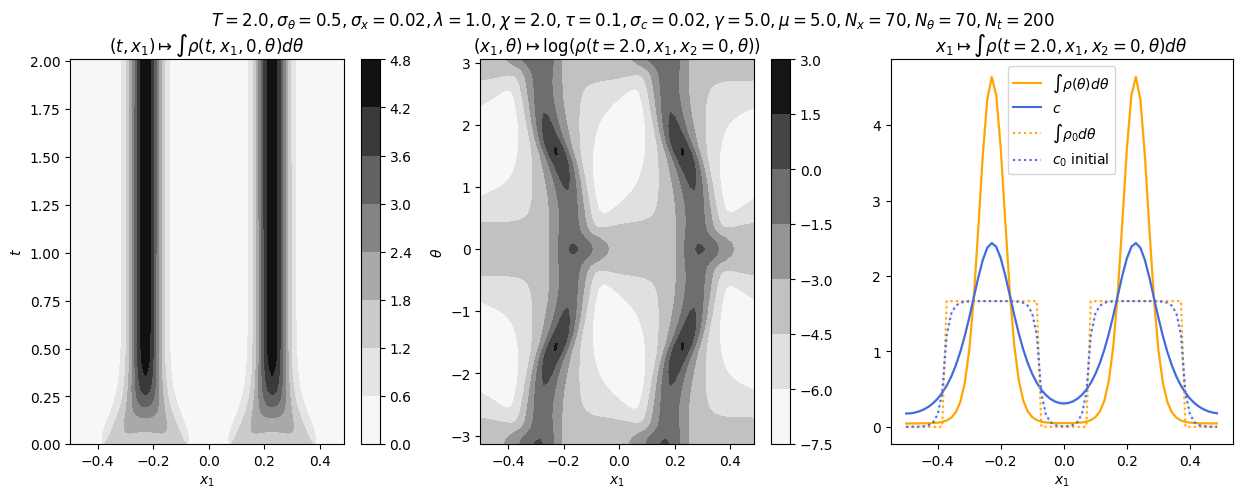

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

cntDenstime = axs[0].contourf(Xtime.T, T.T, Fx.T, cmap='Greys')
axs[0].set_xlabel(r'$x_1$')
axs[0].set_ylabel(r'$t$')
axs[0].set_title(r'$(t,x_1)\mapsto \int\rho(t,x_1, 0,\theta)d\theta$')

plt.colorbar(cntDenstime ,ax=axs[0])

cntDens = axs[1].contourf(X, TH, np.log(Fstack[-1]), cmap='Greys')
axs[1].set_xlabel(r'$x_1$')
axs[1].set_ylabel(r'$\theta$')
axs[1].set_title(r'$(x_1, \theta) \mapsto \log(\rho(t = {0:0.1f} ,x_1, x_2 = 0,\theta))$'.format(round(dt*(Nt+1), 2)))

plt.colorbar(cntDens ,ax=axs[1])

for i in range(0,len(Cstack)-1, 60):
    axs[2].plot(x,Fx[i,:], color = 'orange', alpha = .1)
    axs[2].plot(x,Cstack[i], color = 'royalblue', alpha = .1)
axs[2].plot(x,Fx[-1,:], color = 'orange', label=r'$\int\rho(\theta)d\theta$')
axs[2].plot(x,Cstack[-1], color = 'royalblue', label=r'$c$')
axs[2].plot(x,Fx[0,:], color = 'orange', label=r'$\int\rho_0 d\theta$', linestyle='dotted')
axs[2].plot(x,Cstack[0], color = 'royalblue', label=r'$c_0$ initial', linestyle='dotted')
axs[2].set_xlabel(r'$x_1$')
axs[2].legend()
axs[2].set_title(r'$ x_1 \mapsto \int \rho(t = {0:0.1f} ,x_1, x_2 = 0,\theta) d\theta$'.format(dt*(Nt+1)))

fig.suptitle(title)
#plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig(datetime.now().strftime("%m%d%H%M%S")+'Convergence1Dcase.pdf',bbox_inches='tight')